#**머신 러닝을 사용하여 타이타닉호에서 살아남은 승객을 예측하는 모델**

In [4]:
import pandas as pd

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



###Data Dictionary
*  Survived : 0 = No(죽음), 1 = Yes(살아남음)
*  Pcalss : 1 = 퍼스트 클래스, 2 = 두번째 클래스, 3 = 세번째 클래스
*  SibIp : 지인과 같이 탄 명수 
   ex) 1이라면 와이프랑 같이 탔을 수도 혹은 친구랑 같이 탔을 수도 있다
*  Parch : parent+child (부모님과 같이 탔거나 자식과 같이 탔을 수도)

+) Cabin에서 NaN의 데이터는 아무 것도 없는 데이터로 전처리를 해줘야한다.(열 자체를 없애거나 NaN에 평균 값을 넣어주거나)



In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train.shape #891개의 승객정보

(891, 12)

In [8]:
test.shape

(418, 11)

In [9]:
'''
  Age, Cabin, Embarked의 count를 보면 891보다 낮은 숫자가 나온다
  즉, 데이터가 유실되었다는 뜻(NaN)
  이는 머신러닝 모델에 그대로 넣었다가는 잘못된 정보를 야기시킬 수 있다.
  따라서 feature enginnering을 사용해서 의미있는 정보로 바꿔서 모델에 넣어주어야한다.
'''
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train.isnull().sum()  #NULL 데이터의 합계를 표시

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

###시각화 부분

matplot + seaborn 사용

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [12]:
# 살았는지 죽었는지 확인하는 함수
def bar_chart(feature):
  survived = train[train['Survived'] == 1][feature].value_counts()
  dead = train[train['Survived'] == 0][feature].value_counts()

  df = pd.DataFrame([survived, dead])
  df.index = ['Survived', 'Dead']
  df.plot(kind='bar', stacked=True, figsize=(10, 5))

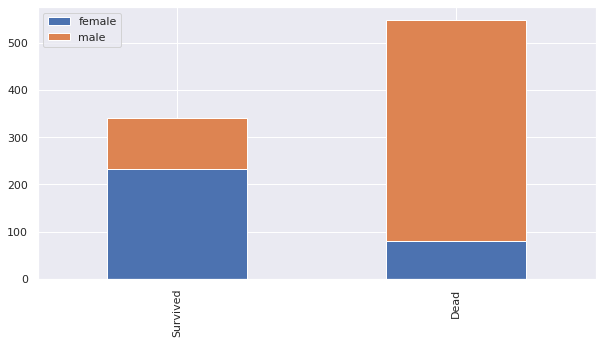

In [13]:
# 차트를 통해 한가지 가설 : 여자는 남자보다 살아남은 확률이 높았다.
bar_chart('Sex')

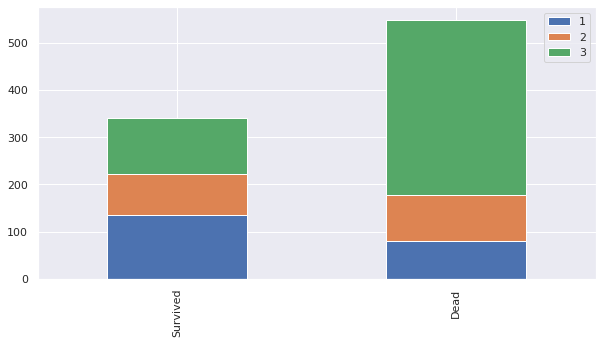

In [14]:
#1등급, 2등급, 3등급의 좌석에 대한 죽음의 확률이 3등급일 때, 높았다.
bar_chart('Pclass')

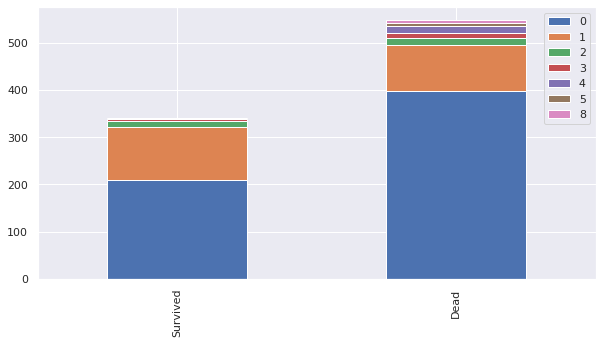

In [15]:
#가족이 있었던 사람들이 살아남을 확률이 더 높았다.
bar_chart('SibSp')

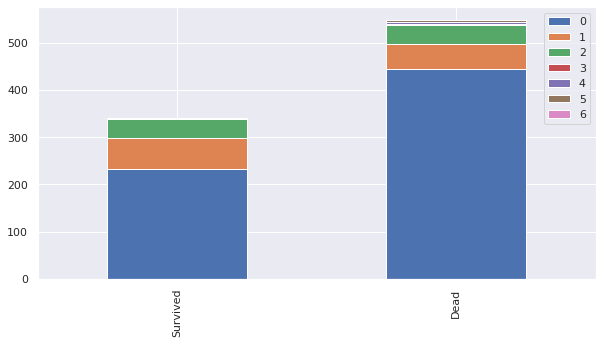

In [16]:
bar_chart('Parch')

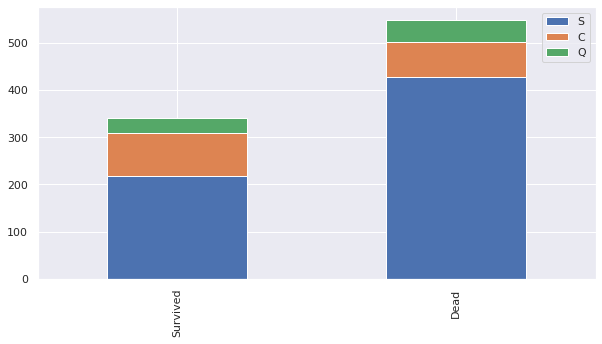

In [17]:
#선착장에 대해서는 가설을 제대로 만들지는 못하였다.
bar_chart("Embarked")

# Featrue Engineering

Feature : 데이터의 컬럼
이 Feature들을 feature vector로 만들어줘야한다.

안의 내용들을 전부 숫자로 만들어서 넣어줄거고, NaN 데이터도 다른 숫자로 만들어서 데이터에 넣어줄 예정이다.

#**Name**

이름이 무엇이냐에 따라서는 죽음의 확률에 대해 영향이 없겠지만
그 이름의 Mrs, Mis 등 불리는 말에 따라 여자인지 남자인지 결혼을 했는지 안했는지 알 수 있기 때문에 이 부분은 죽고 사느냐에 따라 영향이 끼칠 수 있다고 가설을 세움

In [18]:
train_test_data = [train, test]

for dataset in train_test_data:
  dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [19]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Don           1
Lady          1
Jonkheer      1
Ms            1
Countess      1
Capt          1
Mme           1
Sir           1
Name: Title, dtype: int64

In [20]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

In [21]:
'''
  Mr : 0
  Miss : 1
  Mrs : 2
  Others : 3
'''
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3 }

for dataset in train_test_data:
  dataset['Title'] = dataset['Title'].map(title_mapping)

In [22]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


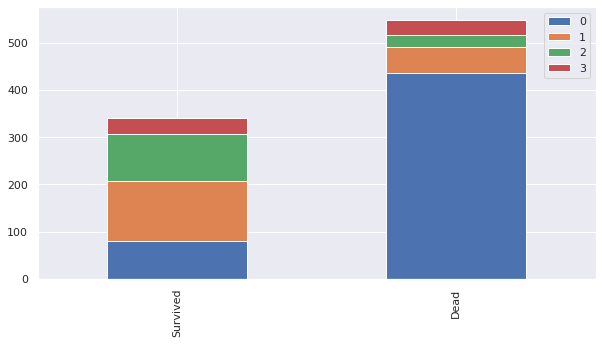

In [23]:
bar_chart('Title')

In [24]:
test.drop('Name', axis=1, inplace=True)
train.drop('Name', axis=1, inplace=True)

#**Age**

male : 0
female : 1

In [25]:
sex_mapping = {"male" : 0, "female" : 1}

for dataset in train_test_data:
  dataset['Sex'] = dataset['Sex'].map(sex_mapping)

In [26]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0


#**Age**

NaN : 가장 기본적인 생각은 평균을 넣어주는 것 \
      하지만 여기서는 좀 더 과학적으로 Title을 통해 결혼한 남자/ 싱글 남자 / 결혼한 여자 / 싱글 여자 각각 평균을 넣어주었다.

In [27]:
# Age가 null일 경우(fillna) 각 Title별로 age의 median(중간값)을 사용해라 ("mean" 평균값을 사용해도 됨)
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [28]:
train.head(30)
train.groupby("Title")["Age"].transform("median")

0      30.0
1      35.0
2      21.0
3      35.0
4      30.0
       ... 
886     9.0
887    21.0
888    21.0
889    30.0
890    30.0
Name: Age, Length: 891, dtype: float64

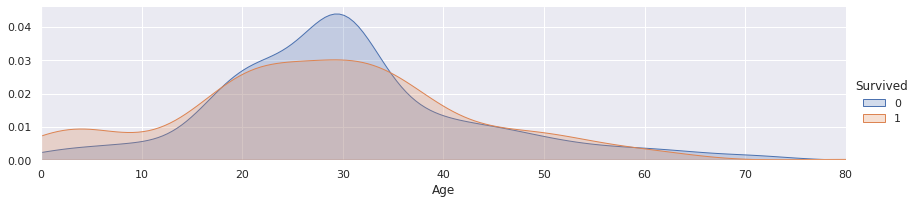

In [29]:
facet = sns.FacetGrid(train, hue="Survived", aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()

plt.show()

(40.0, 60.0)

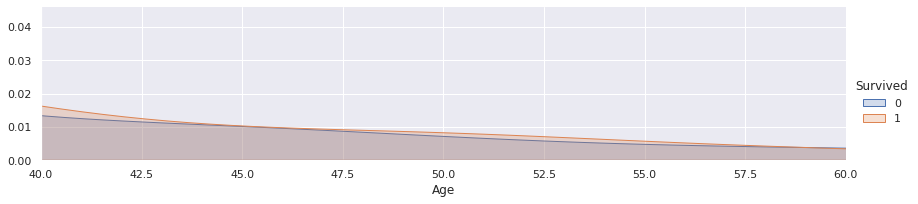

In [30]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train['Age'].max()))
facet.add_legend()
plt.xlim(40, 60) # 40대부터 60대까지

# Binning
즉, 이렇게 sequential한 정보가 있을때는 각각 하나에 카테고리 별로 정보를 담는 기술

feature vector map:
child : 0\
young : 1\
adult : 2\
min-age : 3\
senior : 4

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Title        891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Ticket       418 non-null    object 
 7   Fare         417 non-null    float64
 8   Cabin        91 non-null     object 
 9   Embarked     418 non-null    object 
 10  Title        418 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 36.0+ KB


In [33]:
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4

In [34]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,S,0


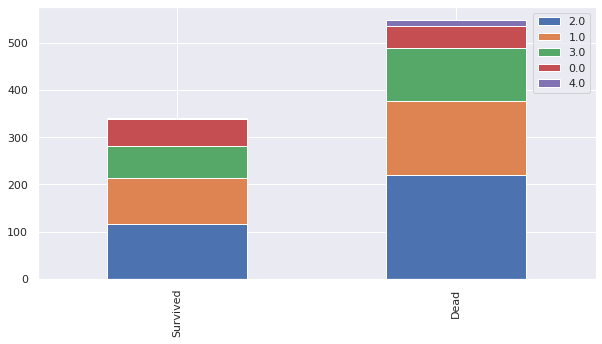

In [35]:
#나이가 많으신 분들은 많이 돌아가셨고
#나이가 어리면 살 확률이 높았다
bar_chart('Age')

#Embarked

어디서 탔는지

A : 부자 동네 즉, 1등급에 탔을 확률이 높았다\
B : 못사는 동네 즉, 3등급을 탔을 확률이 높음

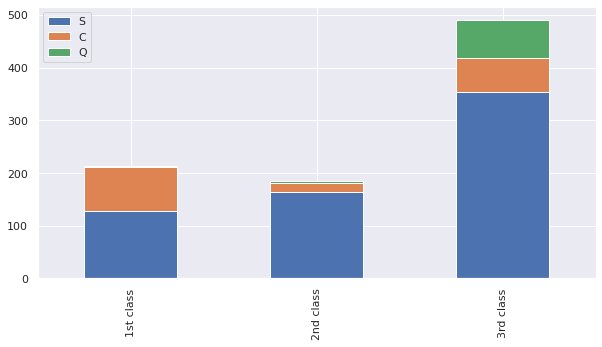

In [36]:
# Q - 2, 3등급에 많이 분포
# S - 전체적으로 분포 따라서, embarked 정보가 없다면 S에 넣기
Pclass1 = train[train['Pclass'] == 1]['Embarked'].value_counts()
Pclass2 = train[train['Pclass'] == 2]['Embarked'].value_counts()
Pclass3 = train[train['Pclass'] == 3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10, 5))

In [37]:
for dataset in train_test_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,S,0


In [38]:
embarked_mapping = {'S':0, 'C':1, 'Q':2}
for dataset in train_test_data:
  dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

#Fare

티켓 가격이 NaN인 경우 -> 티켓 클래스와 연관해서 그 곳의 가운데 값에 넣어주기\
1등급의 가운데 값을 -> 1등급 NaN에 넣기\
등등

In [39]:
train['Fare'].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test['Fare'].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

train.head(30)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,0,0
5,6,0,3,0,2.0,0,0,330877,8.4583,NaN,2,0
6,7,0,1,0,3.0,0,0,17463,51.8625,E46,0,0
7,8,0,3,0,0.0,3,1,349909,21.0750,NaN,0,3
8,9,1,3,1,2.0,0,2,347742,11.1333,NaN,0,2
9,10,1,2,1,0.0,1,0,237736,30.0708,NaN,1,2


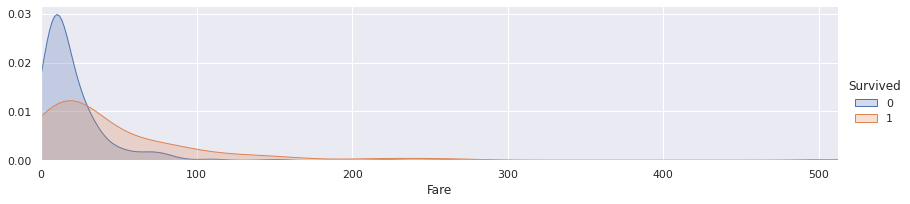

In [40]:
#싼 티켓은 많은 사람들이 죽었고
#비싼 티켓은 적은 사람들이 죽었다.
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train['Fare'].max()))
facet.add_legend()

plt.show()

In [41]:
for dataset in train_test_data:
  dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3
  
train.head(30)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,NaN,0,0
1,2,1,1,1,3.0,1,0,PC 17599,2.0,C85,1,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,NaN,0,1
3,4,1,1,1,2.0,1,0,113803,2.0,C123,0,2
4,5,0,3,0,2.0,0,0,373450,0.0,NaN,0,0
5,6,0,3,0,2.0,0,0,330877,0.0,NaN,2,0
6,7,0,1,0,3.0,0,0,17463,2.0,E46,0,0
7,8,0,3,0,0.0,3,1,349909,1.0,NaN,0,3
8,9,1,3,1,2.0,0,2,347742,0.0,NaN,0,2
9,10,1,2,1,0.0,1,0,237736,2.0,NaN,1,2


#Cabin

호텔의 방같은 거

In [42]:
train.Cabin.value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
E101           3
F33            3
              ..
C103           1
D6             1
C47            1
B50            1
C85            1
Name: Cabin, Length: 147, dtype: int64

In [43]:
for dataset in train_test_data:
  dataset['Cabin'] = dataset['Cabin'].str[:1]

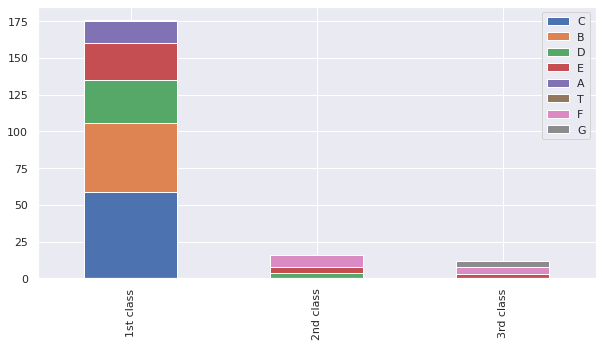

In [44]:
# 1등급은 A, B, C, D, E
# 2등급은 D, E, F
Pclass1 = train[train['Pclass']==1]['Cabin'].value_counts()
Pclass2 = train[train['Pclass']==2]['Cabin'].value_counts()
Pclass3 = train[train['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class','2nd class', '3rd class']
df.plot(kind='bar',stacked=True, figsize=(10,5))

#feature Scaling

mapping하는데 소수점을 사용한 이유는 머신러닝 classifier는 유클리디안 디스턴스를 사용하기 때문에 범위를 비슷하게 해줘야한다.

In [45]:
cabin_mapping = {"A": 0, "B": 0.4, "C": 0.8, "D": 1.2, "E": 1.6, "F": 2, "G": 2.4, "T": 2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)

In [46]:
# fill missing Fare with median fare for each Pclass
train["Cabin"].fillna(train.groupby("Pclass")["Cabin"].transform("median"), inplace=True)
test["Cabin"].fillna(test.groupby("Pclass")["Cabin"].transform("median"), inplace=True)

#FamilySize


In [47]:
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,2.0,0,0,2
1,2,1,1,1,3.0,1,0,PC 17599,2.0,0.8,1,2,2
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,2.0,0,1,1
3,4,1,1,1,2.0,1,0,113803,2.0,0.8,0,2,2
4,5,0,3,0,2.0,0,0,373450,0.0,2.0,0,0,1


(0.0, 11.0)

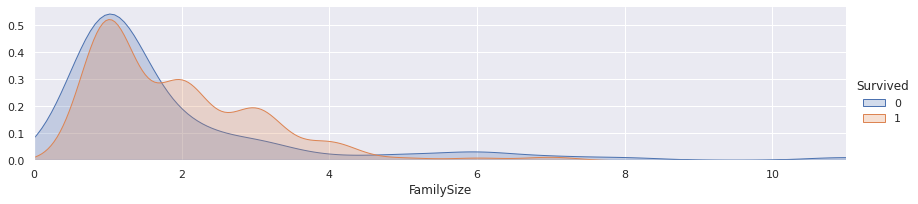

In [48]:
facet = sns.FacetGrid(train, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'FamilySize',shade= True)
facet.set(xlim=(0, train['FamilySize'].max()))
facet.add_legend()
plt.xlim(0)

In [49]:
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
for dataset in train_test_data:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)


In [50]:
features_drop = ['Ticket', 'SibSp', 'Parch']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

In [51]:
train_data = train.drop('Survived', axis=1)
target = train['Survived']

train_data.shape, target.shape

((891, 8), (891,))

In [52]:
train_data.head(10)

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,3.0,2.0,0.8,1,2,0.4
2,3,1,1.0,0.0,2.0,0,1,0.0
3,1,1,2.0,2.0,0.8,0,2,0.4
4,3,0,2.0,0.0,2.0,0,0,0.0
5,3,0,2.0,0.0,2.0,2,0,0.0
6,1,0,3.0,2.0,1.6,0,0,0.0
7,3,0,0.0,1.0,2.0,0,3,1.6
8,3,1,2.0,0.0,2.0,0,2,0.8
9,2,1,0.0,2.0,1.8,1,2,0.4


#Modelling


In [53]:
# Importing Classifier Modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import numpy as np

#**Cross Vaildation (K-flod)**

In [54]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits = 10, shuffle=True, random_state=0)

#**KNN**

In [56]:
clf = KNeighborsClassifier(n_neighbors= 13)    # 13개의 K를 사용
scoring = "accuracy"
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.82222222 0.76404494 0.80898876 0.83146067 0.87640449 0.82022472
 0.85393258 0.79775281 0.84269663 0.84269663]


In [57]:
round(np.mean(score)*100, 2) 

82.6

#**Decision Tree**

In [58]:
clf = DecisionTreeClassifier()
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.76666667 0.83146067 0.7752809  0.7752809  0.87640449 0.76404494
 0.82022472 0.82022472 0.74157303 0.78651685]


In [62]:
round(np.mean(score)*100, 2)

79.58

#**Ramdom Forest**

In [63]:
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.8        0.80898876 0.82022472 0.78651685 0.85393258 0.78651685
 0.80898876 0.82022472 0.74157303 0.80898876]


In [64]:
round(np.mean(score)*100, 2)

80.36

#**Naive Bayes**

In [65]:
clf = GaussianNB()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.85555556 0.73033708 0.75280899 0.75280899 0.70786517 0.80898876
 0.76404494 0.80898876 0.86516854 0.83146067]


In [66]:
round(np.mean(score)*100, 2)

78.78

#**SVM**

In [67]:
clf = SVC()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.83333333 0.79775281 0.83146067 0.82022472 0.84269663 0.82022472
 0.84269663 0.85393258 0.84269663 0.86516854]


In [68]:
round(np.mean(score)*100, 2)

83.5

#**Testing**


In [69]:
clf = SVC()
clf.fit(train_data, target)

test_data = test.drop("PassengerId", axis=1).copy()
prediction = clf.predict(test_data)

In [72]:
submission = pd.DataFrame({
    "PassengerId" : test["PassengerId"],
    "Survived" : prediction
})

submission.to_csv('submission.csv', index=False)

In [73]:
submission = pd.read_csv('submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
